## Main Notebook: Strategies Investigation for **Settlement Risk**

### Overview

This notebook analyses the exposure and performance of the strategies for settlement risk

---
### **SETUP:** Define all the programs we will use
--- 

#### **Step 1**: Import Modules
---

In [60]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

#### **Step 2**: Build the Baseline and Transactions (Impacts) that we will use
---

In [61]:

# Columns correspond to CURRENCIES
# Column 1: USD
# Column 2: GBP
# Column 3: EUR
# Column 4: AUD
# Column 5: JPY

def get_baseline_positions(n, baseline_min, baseline_max):

    baseline = np.zeros((1,5))


    baseline[0][0] = random.randint(baseline_min, baseline_max)
    baseline[0][1] = random.randint(baseline_min, baseline_max)
    baseline[0][2] = random.randint(baseline_min, baseline_max)
    baseline[0][3] = random.randint(baseline_min, baseline_max)
    baseline[0][4] = random.randint(baseline_min, baseline_max)

    '''
    baseline[0][0]  = random.randint(-100,100)
    baseline[0][1] = -baseline[0][0]
    baseline[0][2] = random.randint(-100,100)
    baseline[0][3] = -baseline[0][2]
    baseline[0][4] = random.randint(-100,100)
    '''

    #print("Initial Baseline", baseline)


    # there are C(5,2) = 5!/(5-2)!(2!) = 10 unique pairs for the exchange rates


    exchange_rate_1_2 = 2
    exchange_rate_1_3 = 0.5
    exchange_rate_1_4 = 1.5
    exchange_rate_1_5 = 3

    exchange_rate_2_3 = 0.5
    exchange_rate_2_4 = 1.25
    exchange_rate_2_5 = 0.75

    exchange_rate_3_4 = 2
    exchange_rate_3_5 = 0.5

    exchange_rate_4_5 = 1.5
    
    exchange_rates = np.zeros((5,5))

    for i in range(exchange_rates.shape[0]):
        for j in range(exchange_rates.shape[1]):
            
            if i == j:
                exchange_rates[i][j] = 1  # Set diagonal to 1 (since the exchange rate to itself is 1)
            else:
                # Assign the exchange rates based on (i,j) index
                if i == 0 and j == 1:
                    exchange_rates[i][j] = exchange_rate_1_2
                elif i == 0 and j == 2:
                    exchange_rates[i][j] = exchange_rate_1_3
                elif i == 0 and j == 3:
                    exchange_rates[i][j] = exchange_rate_1_4
                elif i == 0 and j == 4:
                    exchange_rates[i][j] = exchange_rate_1_5
                elif i == 1 and j == 2:
                    exchange_rates[i][j] = exchange_rate_2_3
                elif i == 1 and j == 3:
                    exchange_rates[i][j] = exchange_rate_2_4
                elif i == 1 and j == 4:
                    exchange_rates[i][j] = exchange_rate_2_5
                elif i == 2 and j == 3:
                    exchange_rates[i][j] = exchange_rate_3_4
                elif i == 2 and j == 4:
                    exchange_rates[i][j] = exchange_rate_3_5
                elif i == 3 and j == 4:
                    exchange_rates[i][j] = exchange_rate_4_5
                else:
                    # For reverse exchange rates (j to i), set as reciprocal
                    exchange_rates[i][j] = 1 / exchange_rates[j][i]

    transactions = np.zeros((n,5))

    for i in range(n):

        currency = random.randint(0,4)
        remaining_numbers = [x for x in range(5) if x!= currency]
        counter_currency = random.choice(remaining_numbers)

        buy_or_sell = random.randint(0,1)

        if buy_or_sell == 0:
            transactions[i,currency] = random.randint(5,10)
            transactions[i, counter_currency] = -transactions[i,currency]*exchange_rates[currency][counter_currency]
        elif buy_or_sell == 1:
            transactions[i,currency] = random.randint(-10,-5)
            transactions[i, counter_currency] = transactions[i,currency]*exchange_rates[currency][counter_currency]*(-1)


    positions = np.vstack([baseline, transactions])

    #print(positions)

    return positions

#### **Step 3**: Define Settlement Risk function
---

In [62]:
def SettlementRisk(position):
    return np.sum(np.maximum(0,position))

#### **Step 4:** Define our strategies
---

In [63]:
def BruteForce(positions):

    bf_list = []
    total_position = np.zeros((1,5))
    
    
    total_position = np.vstack([total_position, positions[0,:]])
    total = SettlementRisk(total_position)
    bf_list.append(total)

    for i in range(positions.shape[0]-1):
        total_position = np.vstack([total_position, positions[i+1,:]])

        temp =  np.sum(total_position, axis=0)
        total = SettlementRisk(temp)
        bf_list.append(total)
    
    #total_position = np.sum(positions, axis=0)

    return [SettlementRisk(total), bf_list]


def Linearisation(positions):

    lin_list = []
    baseline = positions[0,:]

    baseline_exposure = SettlementRisk(baseline)

    total = baseline_exposure
    lin_list.append(total)

    for i in range(positions.shape[0]-1):
        decoupled = np.vstack([baseline, positions[i+1,:]])
        decoupled = np.sum(decoupled, axis=0)
                
        decoupled_exposure = SettlementRisk(decoupled)
        total += decoupled_exposure - baseline_exposure
        lin_list.append(total)

    return [total, lin_list]

def Conservative(positions):

    total = 0
    cons_list = []
    for i in range(positions.shape[0]):

        total += SettlementRisk(positions[i,:])
        cons_list.append(total)

    return [total, cons_list]

def Averages(positions):
    avg_list = []
    baseline = positions[0,:]
    n = positions.shape[0]-1
    baseline_exposure = SettlementRisk(baseline)

    total = baseline_exposure
    avg_list.append(total)

    for i in range(positions.shape[0]-1):

        decoupled = np.vstack([baseline, positions[i+1,:]])
        decoupled[1] *= n
        decoupled = np.sum(decoupled, axis=0)
        decoupled_exposure = SettlementRisk(decoupled)
        total += 1/n*(decoupled_exposure - baseline_exposure)
        avg_list.append(total)

    return [total, avg_list]

In [64]:
# Tester Dataset

'''
data = np.array([[ 10., -10.,  5.,  -5.,  20. ],
                [ -5.,   0.,  2.5,  0.,   0.  ],
                [  7., -14.,  0.,   0.,   0.  ],
                [  0.,   0.,  6., -12.,  0.  ],
                [  0.,   0., 10.,  0.,  -5.  ],
                [  0.,   8.,  0., -10.,  0.  ]])
'''

'\ndata = np.array([[ 10., -10.,  5.,  -5.,  20. ],\n                [ -5.,   0.,  2.5,  0.,   0.  ],\n                [  7., -14.,  0.,   0.,   0.  ],\n                [  0.,   0.,  6., -12.,  0.  ],\n                [  0.,   0., 10.,  0.,  -5.  ],\n                [  0.,   8.,  0., -10.,  0.  ]])\n'

#### **Step 5:** Define the simulation function
---

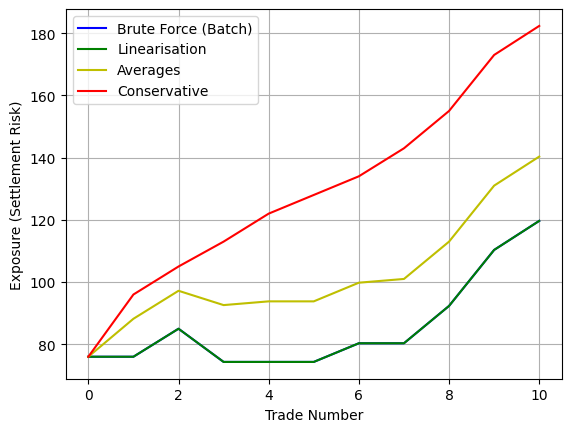

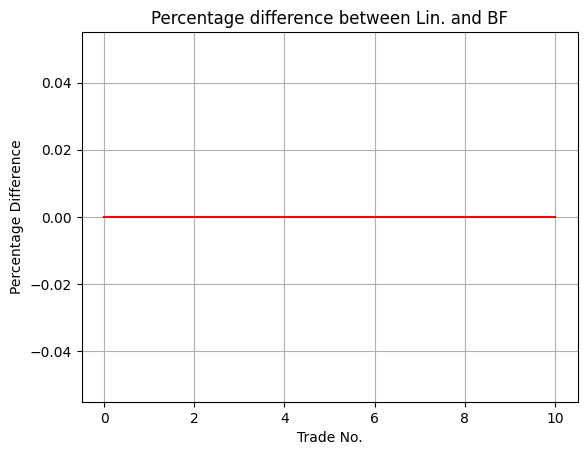

Largest percentage difference between BF and Lin:  0.0




NOTE: Positive percentage implies linearisation is working correctly (overestimating)
      Negative percentage implies linearisation is optimistic (underestimating exposure)


In [65]:
def sim(m, baseline_min, baseline_max):

    data = get_baseline_positions(m, baseline_min, baseline_max)

    [total_BF, bf_list] = BruteForce(data)
    [total_Linearisation, lin_list] = Linearisation(data)
    [total_Conservative, cons_list] = Conservative(data)
    [total_Averages, avg_list] = Averages(data)

    '''
    print("Brute Force: ", total_BF)
    print("\n")
    print("Linearisation: ", total_Linearisation)
    print("\n")
    print("Conservative: ", total_Conservative)
    print("\n")
    print("Averages: ", total_Averages)
    '''


    x = np.linspace(0,m,m+1)

    plt.figure()
    plt.plot(x,bf_list, label="Brute Force (Batch)", color= "b")
    plt.plot(x,lin_list, label="Linearisation", color= "g")
    plt.plot(x,avg_list, label="Averages", color= "y")
    plt.plot(x,cons_list, label="Conservative", color= "r")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Trade Number")
    plt.ylabel("Exposure (Settlement Risk)")
    plt.show()


    diff_lin_bf = [(lin_list[i] - bf_list[i])/bf_list[i]*100 for i in range(len(lin_list))]
    min = np.min(diff_lin_bf)
    max = np.max(diff_lin_bf)

    plt.figure()

    plt.plot(x, diff_lin_bf, color="r")
    plt.xlabel("Trade No.")
    plt.ylabel("Percentage Difference")
    plt.title("Percentage difference between Lin. and BF")
    plt.grid(True)
    plt.show()

    if abs(min) > abs(max):
        print("Largest percentage difference between BF and Lin: ", min)
    else:
        print("Largest percentage difference between BF and Lin: ", max)

    print("\n")
    print("\n")
    print("NOTE: Positive percentage implies linearisation is working correctly (overestimating)")
    print("      Negative percentage implies linearisation is optimistic (underestimating exposure)")
sim(10, -100, 100)

#### **Step 6:** INTERACTIVE GRAPH
---

In [66]:
''' 
widgets.interact(sim,
         m = widgets.IntSlider(min=0,max=100,step=1,value=20,description="Total No. Trades"),
         baseline_min = widgets.IntSlider(min=-200,max=-20,step=1,value=-50,description="Min. range of Baseline position"),
         baseline_max = widgets.IntSlider(min=20,max=200,step=1,value=50,description="Max. range of baseline position"),
         )
         '''

' \nwidgets.interact(sim,\n         m = widgets.IntSlider(min=0,max=100,step=1,value=20,description="Total No. Trades"),\n         baseline_min = widgets.IntSlider(min=-200,max=-20,step=1,value=-50,description="Min. range of Baseline position"),\n         baseline_max = widgets.IntSlider(min=20,max=200,step=1,value=50,description="Max. range of baseline position"),\n         )\n         '

In [67]:
# Define the sliders
m_slider = widgets.IntSlider(min=0, max=100, step=1, value=20, description="Total No. Trades")
baseline_min_slider = widgets.IntSlider(min=-200, max=200, step=1, value=-50, description="Min. range of Baseline position")
baseline_max_slider = widgets.IntSlider(min=-200, max=200, step=1, value=50, description="Max. range of Baseline position")

# Preset button functionality
def set_preset_1(b):
    m_slider.value = 50
    baseline_min_slider.value = -100
    baseline_max_slider.value = -50

def set_preset_2(b):
    m_slider.value = 50
    baseline_min_slider.value = 100
    baseline_max_slider.value = 150

def set_preset_3(b):
    m_slider.value = 50
    baseline_min_slider.value = -100
    baseline_max_slider.value = 100

# Create preset buttons
preset_button_1 = widgets.Button(description="Negative Baseline")
preset_button_2 = widgets.Button(description="Positive Baseline")
preset_button_3 = widgets.Button(description="Mixed Baseline")

# Attach the button click events to the preset functions
preset_button_1.on_click(set_preset_1)
preset_button_2.on_click(set_preset_2)
preset_button_3.on_click(set_preset_3)

# Set the size of the buttons
preset_button_1.layout = widgets.Layout(width='200px', height='40px')
preset_button_2.layout = widgets.Layout(width='200px', height='40px')
preset_button_3.layout = widgets.Layout(width='200px', height='40px')

# Layout for sliders and buttons
grid_layout = widgets.GridBox(
    children=[m_slider, baseline_min_slider, baseline_max_slider],
    layout=widgets.Layout(grid_template_columns="repeat(4, 300px)", grid_gap="10px")
)

button_layout = widgets.HBox([preset_button_1, preset_button_2, preset_button_3])

# Create interactive output
ui = widgets.VBox([grid_layout, button_layout])
out = widgets.interactive_output(sim, {
    'm': m_slider,
    'baseline_min': baseline_min_slider,
    'baseline_max': baseline_max_slider
})

# Display the widgets
display(ui, out)

Output()